In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

from random import randint
import numpy as np
import torch

from sklearn.decomposition import PCA
import time
from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package punkt to /Users/erikrozi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('datasets/lcp_single_train.tsv', delimiter='\t')
complexity = df['complexity']
sentences = df['sentence']

df_trial = pd.read_csv('datasets/lcp_single_trial.tsv', delimiter='\t')
trial_complexity = df_trial['complexity']
trial_sentences = df_trial['sentence']

In [25]:
def plotCharts(predictions, truth):
    plt.plot(predictions, truth, 'o')
    plt.title("Predictions vs. truth on the trial set")
    plt.savefig("trial_regression.png")
    plt.show()

    plt.plot(predictions, predictions - truth, 'o')
    plt.title("Predicted vs L1 error no abs")
    plt.show()

    plt.plot(trial_complexity, predictions - truth, 'o')
    std = np.std(predictions - trial_complexity)
    plt.title("Truth vs L1 error no abs, STD: {}".format(round(std, 4)))
    plt.show()

### Download Glove and fastText

In [ ]:
#!mkdir encoder
#!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [ ]:
#!mkdir fastText
#!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
#!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [ ]:
#unzip glove.840B.300d.zip, filepath may vary

#!unzip GloVe/glove.840B.300d.zip -d GloVe/

# Load Infersent and Build Embeddings

In [3]:
from models import InferSent

# Change V=2 if using fastText
V = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
MODEL_PATH = 'encoder/infersent%s.pkl' % V
infersent.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [4]:
#infersent.set_w2v_path('fastText/crawl-300d-2M.vec')
infersent.set_w2v_path('GloVe/glove.840B.300d.txt')

In [5]:
infersent.build_vocab(sentences, tokenize=True)
# infersent.build_vocab_k_words(K=100000)

Found 16161(/18540) words with w2v vectors
Vocab size : 16161


In [28]:
embeddings_ = infersent.encode(sentences, tokenize=True)

In [29]:
trial_embeddings_ = infersent.encode(trial_sentences, tokenize=True)

# Create Model with PCA

In [32]:
model = PCA(n_components=100)
model.fit(embeddings_)
embeddings  = model.transform(embeddings_)
trial_embeddings = model.transform(trial_embeddings_)

Train R^2 0.1080849703470751
Train L1: 0.09746323985596561
Trial R^2: 0.16579390538999672
Trial L1: 0.10518014521346601


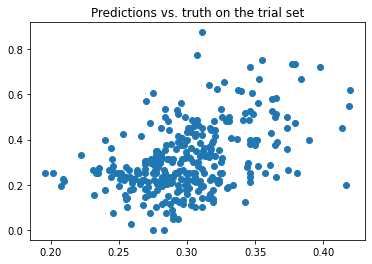

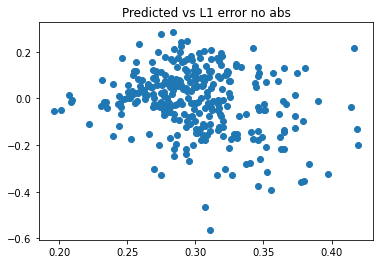

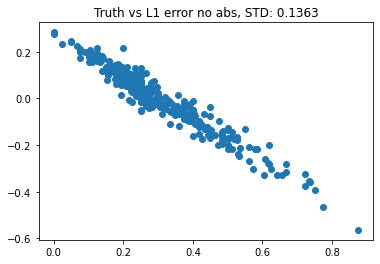

In [33]:
linreg = LinearRegression()
complexity = df['complexity']
sentences = df['sentence']

linreg.fit(embeddings, complexity)
predictions = linreg.predict(embeddings)
print("Train R^2", linreg.score(embeddings, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
trial_predictions = linreg.predict(trial_embeddings)
print("Trial R^2:", linreg.score(trial_embeddings, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

plotCharts(trial_predictions, trial_complexity)